# Cell 1: Imports and Setup

In [9]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add current directory to path to access Core/Utils modules
sys.path.append(os.getcwd())

from Core.models import Sequential
from Core.layers import RoughRBFLayer, RoughGMDHLayer
from Core.losses import MSELoss
from Core.optimizers import SGD
from Utils.data_utils import DataHandler

# Visualization Setup
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully. Ready for Question 4.")

Libraries imported successfully. Ready for Question 4.


# Cell 2: Data Loading and Preprocessing

In [10]:
# 1. Define Paths
TEHRAN_PATH = '../HW2/Datasets/regression/Tehran Stock Exchange-index.xlsx'
LORENZ_PATH = '../HW2/Datasets/regression/Lorenz Dataset.xlsx'

# 2. Load Data
print("Loading Datasets...")
tehran_raw = DataHandler.load_data(TEHRAN_PATH)
lorenz_raw = DataHandler.load_data(LORENZ_PATH)

# 3. Normalize Data (Crucial for RBF/GMDH stability)
tehran_norm, _ = DataHandler.normalize_data(tehran_raw)
lorenz_norm, _ = DataHandler.normalize_data(lorenz_raw)

# 4. Create Sequences
# Constraint: 5 input steps, predict 3rd step ahead
INPUT_STEPS = 5
PRED_HORIZON = 3

X_teh, y_teh = DataHandler.create_sequences(tehran_norm, INPUT_STEPS, PRED_HORIZON)
X_lor, y_lor = DataHandler.create_sequences(lorenz_norm, INPUT_STEPS, PRED_HORIZON)

# 5. Train/Test Split (No shuffle for Time Series)
X_train_teh, X_test_teh, y_train_teh, y_test_teh = DataHandler.train_test_split(X_teh, y_teh, 0.7, shuffle=False)
X_train_lor, X_test_lor, y_train_lor, y_test_lor = DataHandler.train_test_split(X_lor, y_lor, 0.7, shuffle=False)

print(f"Tehran Data: Train={X_train_teh.shape}, Test={X_test_teh.shape}")
print(f"Lorenz Data: Train={X_train_lor.shape}, Test={X_test_lor.shape}")

Loading Datasets...
Tehran Data: Train=(345, 5), Test=(148, 5)
Lorenz Data: Train=(1395, 5), Test=(598, 5)


# Cell 3: Hybrid Model Builder

In [11]:
# Cell 3: Hybrid Model Builder (Corrected)
from Core.layers import DenseLayer # Import DenseLayer for final aggregation

def build_hybrid_network(input_seq_len, num_rbf_kernels):
    """
    Constructs the hybrid network: Input -> Rough RBF -> Rough GMDH -> Dense Aggregation -> Output.
    """
    model = Sequential()
    
    # Layer 1: Rough RBF
    # Output dimension: 2 * num_rbf_kernels (because of Lower/Upper split)
    rbf_layer = RoughRBFLayer(input_dim=input_seq_len, num_kernels=num_rbf_kernels)
    model.add(rbf_layer)
    
    # Layer 2: Rough GMDH
    # Input dim is the output of RBF (2 * K)
    gmdh_input_dim = 2 * num_rbf_kernels
    gmdh_layer = RoughGMDHLayer(input_dim=gmdh_input_dim)
    model.add(gmdh_layer)
    
    # Calculate how many polynomial neurons GMDH produced
    # Formula: n * (n-1) / 2
    num_gmdh_neurons = int(gmdh_input_dim * (gmdh_input_dim - 1) / 2)
    
    # Layer 3: Final Aggregation (The Output Node in Diagram)
    # We need to combine the many GMDH outputs into a single prediction value.
    # Since RoughGMDHLayer returns a combined crisp vector (alpha*L + beta*U), 
    # we use a standard DenseLayer to aggregate them.
    output_layer = DenseLayer(input_dim=num_gmdh_neurons, output_dim=1)
    model.add(output_layer)
    
    print(f"Model Built: RBF({num_rbf_kernels} kernels) -> GMDH({num_gmdh_neurons} neurons) -> Output(1)")
    return model

print("Model builder function updated with Aggregation Layer.")

Model builder function updated with Aggregation Layer.


# Cell 4: Training on Tehran Stock Exchange

In [12]:
print("--- Training Hybrid RBF-GMDH on Tehran Stock Exchange ---")

# 1. Build Model
# Using 6 Kernels to keep GMDH complexity manageable 
# (6 kernels -> 12 outputs -> 66 polynomial pairs in GMDH)
model_teh = build_hybrid_network(input_seq_len=5, num_rbf_kernels=6)

# 2. Compile
# Using small Learning Rate because GMDH polynomial terms (x^2) can cause large gradients
optimizer = SGD(lr=0.005, lr_centers=0.005, lr_sigmas=0.005) 
loss_fn = MSELoss()

model_teh.compile(loss=loss_fn, optimizer=optimizer)

# 3. Train
history_teh = model_teh.fit(X_train_teh, y_train_teh, 
                            validation_data=(X_test_teh, y_test_teh),
                            epochs=100, verbose=True, log_freq=10)

--- Training Hybrid RBF-GMDH on Tehran Stock Exchange ---
Model Built: RBF(6 kernels) -> GMDH(66 neurons) -> Output(1)
Starting Training | Mode: SGD | Epochs: 100 | Samples: 345
Validation enabled | Val Samples: 148


Epoch 1/100: 100%|██████████| 345/345 [00:00<00:00, 451.31sample/s, train_loss=0.00136]


Epoch 1 finished. Train Loss: 0.025794 | Val Loss: 0.021669


Epoch 10/100: 100%|██████████| 345/345 [00:00<00:00, 356.77sample/s, train_loss=0.00014]


Epoch 10 finished. Train Loss: 0.007370 | Val Loss: 0.005262


Epoch 20/100: 100%|██████████| 345/345 [00:00<00:00, 389.75sample/s, train_loss=0.00001]


Epoch 20 finished. Train Loss: 0.001695 | Val Loss: 0.002127


Epoch 30/100: 100%|██████████| 345/345 [00:01<00:00, 268.27sample/s, train_loss=0.00000]


Epoch 30 finished. Train Loss: 0.001349 | Val Loss: 0.001678


Epoch 40/100: 100%|██████████| 345/345 [00:01<00:00, 285.07sample/s, train_loss=0.00000]


Epoch 40 finished. Train Loss: 0.001294 | Val Loss: 0.001557


Epoch 50/100: 100%|██████████| 345/345 [00:00<00:00, 346.83sample/s, train_loss=0.00000]


Epoch 50 finished. Train Loss: 0.001271 | Val Loss: 0.001496


Epoch 60/100: 100%|██████████| 345/345 [00:01<00:00, 317.00sample/s, train_loss=0.00000]


Epoch 60 finished. Train Loss: 0.001256 | Val Loss: 0.001455


Epoch 70/100: 100%|██████████| 345/345 [00:01<00:00, 338.09sample/s, train_loss=0.00000]


Epoch 70 finished. Train Loss: 0.001245 | Val Loss: 0.001425


Epoch 80/100: 100%|██████████| 345/345 [00:00<00:00, 357.45sample/s, train_loss=0.00000]


Epoch 80 finished. Train Loss: 0.001236 | Val Loss: 0.001402


Epoch 90/100: 100%|██████████| 345/345 [00:01<00:00, 313.40sample/s, train_loss=0.00000]


Epoch 90 finished. Train Loss: 0.001227 | Val Loss: 0.001384


Epoch 100/100: 100%|██████████| 345/345 [00:00<00:00, 365.53sample/s, train_loss=0.00000]


Epoch 100 finished. Train Loss: 0.001220 | Val Loss: 0.001370
Training Complete. Time: 55.43s


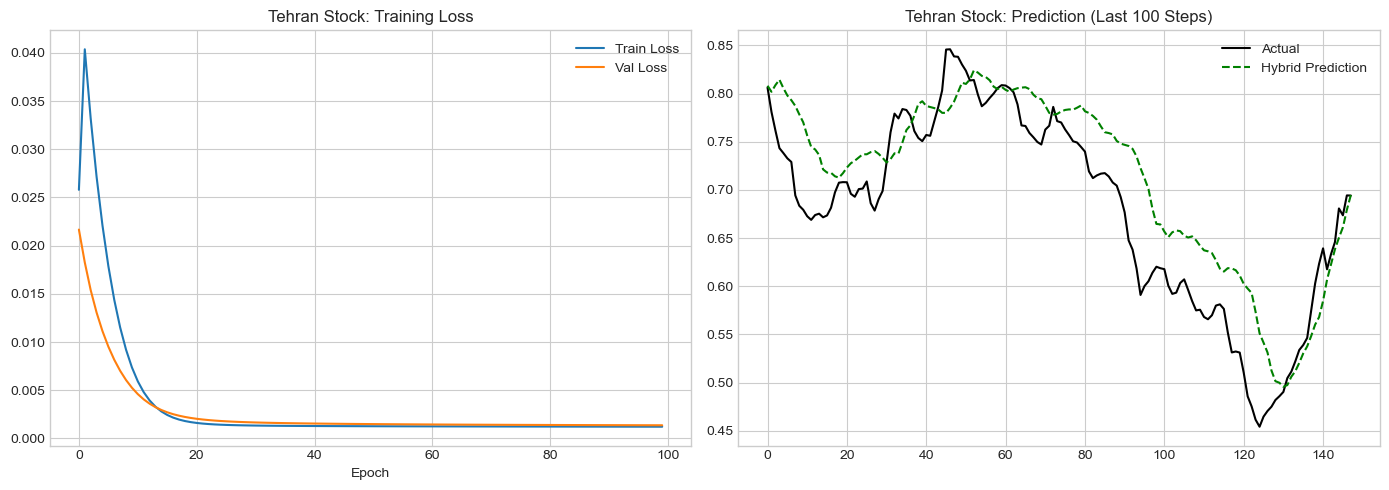

In [20]:
# 4. Visualization
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_teh['loss'], label='Train Loss')
plt.plot(history_teh['val_loss'], label='Val Loss')
plt.title("Tehran Stock: Training Loss")
plt.xlabel("Epoch")
plt.legend()

# Plot Prediction (Zoomed)
plt.subplot(1, 2, 2)
preds_teh = model_teh.predict(X_test_teh)
# Showing last 100 points for clarity
plt.plot(y_test_teh, label='Actual', color='black')
plt.plot(preds_teh.reshape(-1, 1), label='Hybrid Prediction', color='green', linestyle='--')
plt.title("Tehran Stock: Prediction (Last 100 Steps)")
plt.legend()

plt.tight_layout()
plt.show()

# Cell 5: Training on Lorenz Dataset

In [15]:
print("--- Training Hybrid RBF-GMDH on Lorenz Dataset ---")

# 1. Build Model
# Using 8 Kernels for Lorenz (Higher complexity than Stock data)
# (8 kernels -> 16 outputs -> 120 polynomial pairs in GMDH)
model_lor = build_hybrid_network(input_seq_len=5, num_rbf_kernels=8)

# 2. Compile
# Slightly lower LR for stability with more parameters
optimizer = SGD(lr=0.002, lr_centers=0.002, lr_sigmas=0.002)
loss_fn = MSELoss()

model_lor.compile(loss=loss_fn, optimizer=optimizer)

# 3. Train
history_lor = model_lor.fit(X_train_lor, y_train_lor, 
                            validation_data=(X_test_lor, y_test_lor),
                            epochs=100, verbose=True, log_freq=10)

--- Training Hybrid RBF-GMDH on Lorenz Dataset ---
Model Built: RBF(8 kernels) -> GMDH(120 neurons) -> Output(1)
Starting Training | Mode: SGD | Epochs: 100 | Samples: 1395
Validation enabled | Val Samples: 598


Epoch 1/100: 100%|██████████| 1395/1395 [00:04<00:00, 293.50sample/s, train_loss=0.02056]


Epoch 1 finished. Train Loss: 0.025730 | Val Loss: 0.025028


Epoch 10/100: 100%|██████████| 1395/1395 [00:04<00:00, 338.13sample/s, train_loss=0.00320]


Epoch 10 finished. Train Loss: 0.004662 | Val Loss: 0.005093


Epoch 20/100: 100%|██████████| 1395/1395 [00:04<00:00, 284.18sample/s, train_loss=0.00102]


Epoch 20 finished. Train Loss: 0.002808 | Val Loss: 0.003118


Epoch 30/100: 100%|██████████| 1395/1395 [00:04<00:00, 289.74sample/s, train_loss=0.00090]


Epoch 30 finished. Train Loss: 0.002650 | Val Loss: 0.002935


Epoch 40/100: 100%|██████████| 1395/1395 [00:05<00:00, 255.93sample/s, train_loss=0.00088]


Epoch 40 finished. Train Loss: 0.002550 | Val Loss: 0.002816


Epoch 50/100: 100%|██████████| 1395/1395 [00:05<00:00, 264.13sample/s, train_loss=0.00087]


Epoch 50 finished. Train Loss: 0.002463 | Val Loss: 0.002713


Epoch 60/100: 100%|██████████| 1395/1395 [00:05<00:00, 248.25sample/s, train_loss=0.00086]


Epoch 60 finished. Train Loss: 0.002384 | Val Loss: 0.002621


Epoch 70/100: 100%|██████████| 1395/1395 [00:05<00:00, 264.92sample/s, train_loss=0.00084]


Epoch 70 finished. Train Loss: 0.002311 | Val Loss: 0.002536


Epoch 80/100: 100%|██████████| 1395/1395 [00:07<00:00, 198.29sample/s, train_loss=0.00082]


Epoch 80 finished. Train Loss: 0.002243 | Val Loss: 0.002457


Epoch 90/100: 100%|██████████| 1395/1395 [00:06<00:00, 199.93sample/s, train_loss=0.00080]


Epoch 90 finished. Train Loss: 0.002179 | Val Loss: 0.002383


Epoch 100/100: 100%|██████████| 1395/1395 [00:06<00:00, 224.07sample/s, train_loss=0.00078]


Epoch 100 finished. Train Loss: 0.002118 | Val Loss: 0.002313
Training Complete. Time: 333.46s


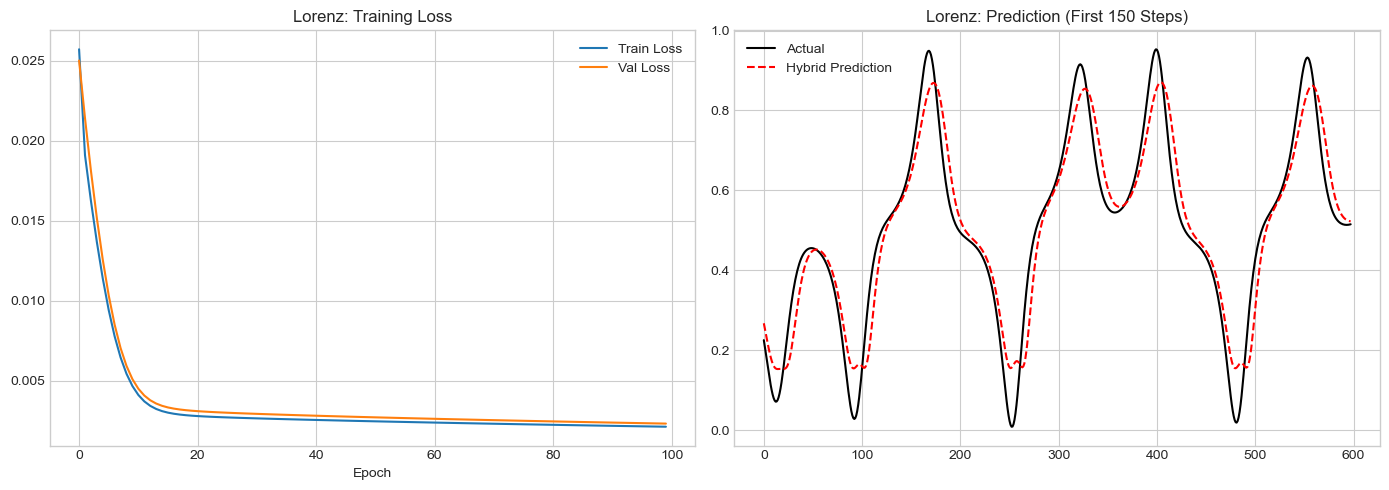

In [18]:
# 4. Visualization
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_lor['loss'], label='Train Loss')
plt.plot(history_lor['val_loss'], label='Val Loss')
plt.title("Lorenz: Training Loss")
plt.xlabel("Epoch")
plt.legend()

# Plot Prediction
plt.subplot(1, 2, 2)
preds_lor = model_lor.predict(X_test_lor)
# Zooming in on a chaotic section
plt.plot(y_test_lor, label='Actual', color='black')
plt.plot(preds_lor.reshape(-1, 1), label='Hybrid Prediction', color='red', linestyle='--')
plt.title("Lorenz: Prediction (First 150 Steps)")
plt.legend()

plt.tight_layout()
plt.show()